In [45]:
!pip install tqdm gdown kornia scipy opencv-python dlib moviepy lpips aubio ninja
!pip install moviepy
!pip install colabutils
!pip install torchfile 
!pip install imageio-ffmpeg
!pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms, utils
from tqdm import tqdm
torch.backends.cudnn.benchmark = True
import copy
from util import *
from PIL import Image

from model import *
import moviepy.video.io.ImageSequenceClip
import scipy
import cv2
import dlib
import kornia.augmentation as K
from aubio import tempo, source

from IPython.display import HTML
from base64 import b64encode
from google.colab import files


In [47]:
device = 'cuda'
latent_dim = 8
n_mlp = 5
num_down = 3

G_A2B = Generator(256, 4, latent_dim, n_mlp, channel_multiplier=1, lr_mlp=.01,n_res=1).to(device).eval()

ensure_checkpoint_exists('GNR_checkpoint.pt')
ckpt = torch.load('GNR_checkpoint.pt', map_location=device)

G_A2B.load_state_dict(ckpt['G_A2B_ema'])

truncation = 1
with torch.no_grad():
    mean_style = G_A2B.mapping(torch.randn([1000, latent_dim]).to(device)).mean(0, keepdim=True)


test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), inplace=True)
])

Saving 48429880_356764408482254_8174507750059933696_n(1).jpg to 48429880_356764408482254_8174507750059933696_n(1) (2).jpg


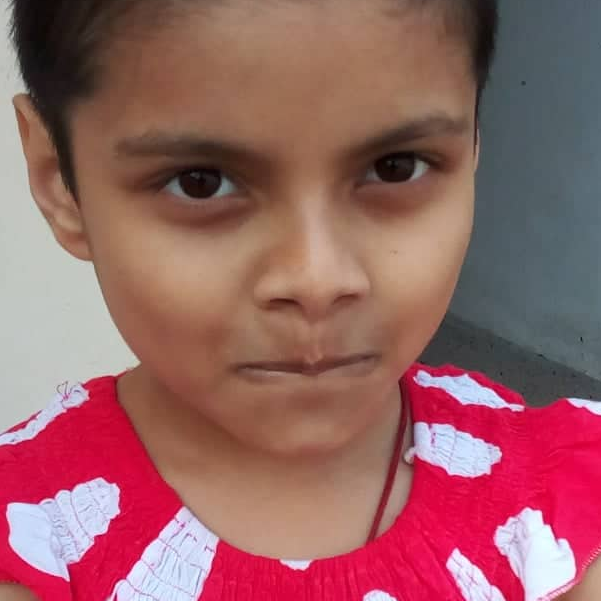

In [48]:

uploaded = files.upload()
filepath = list(uploaded.keys())[0]

image = cv2.imread(filepath)
height, width = image.shape[:2]


face_detector = dlib.get_frontal_face_detector()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

face = face_detector(gray, 1)[0]

x, y, size = get_boundingbox(face, width, height)
cropped_face = image[y:y+size, x:x+size]
cropped_face = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)
cropped_face = Image.fromarray(cropped_face)
cropped_face

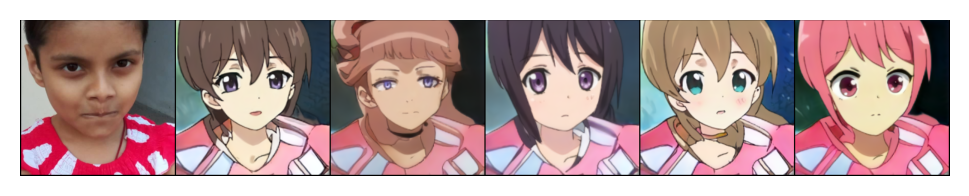

In [49]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 200

torch.manual_seed(84986)

num_styles = 5
style = torch.randn([num_styles, latent_dim]).to(device)

real_A = cropped_face
real_A = test_transform(real_A).unsqueeze(0).to(device)

with torch.no_grad():
    A2B_content, _ = G_A2B.encode(real_A)
    fake_A2B = G_A2B.decode(A2B_content.repeat(num_styles,1,1,1), style)
    A2B = torch.cat([real_A, fake_A2B], 0)

display_image(utils.make_grid(A2B.cpu(), normalize=True, range=(-1, 1), nrow=10))

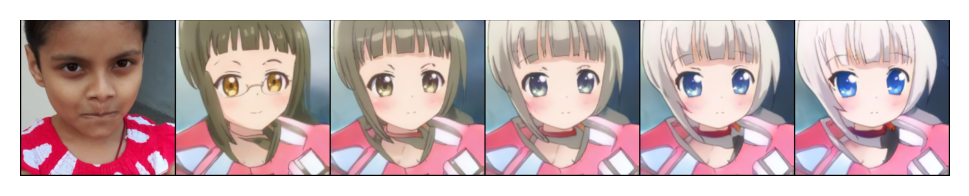

In [50]:
torch.manual_seed(13421)

real_A = cropped_face
real_A = test_transform(real_A).unsqueeze(0).to(device)

style1 = G_A2B.mapping(torch.randn([1, latent_dim]).to(device))
style2 = G_A2B.mapping(torch.randn([1, latent_dim]).to(device))

with torch.no_grad():
    A2B = []
    A2B_content, _ = G_A2B.encode(real_A)
    for i in np.linspace(0,1,5):
        new_style = i*style1 + (1-i)*style2
        fake_A2B = G_A2B.decode(A2B_content, new_style, use_mapping=False)
        A2B.append(torch.cat([fake_A2B], 0))
    A2B = torch.cat([real_A] + A2B, 0)

display_image(utils.make_grid(A2B.cpu(), normalize=True, range=(-1, 1), nrow=10))

In [51]:

modulate = {
    k: v
    for k, v in ckpt["G_A2B_ema"].items()
    if "modulation" in k and "to_rgbs" not in k and "weight" in k
}

weight_mat = []
for k, v in modulate.items():
    weight_mat.append(v)

W = torch.cat(weight_mat, 0)
eigvec = torch.svd(W).V.to("cpu")

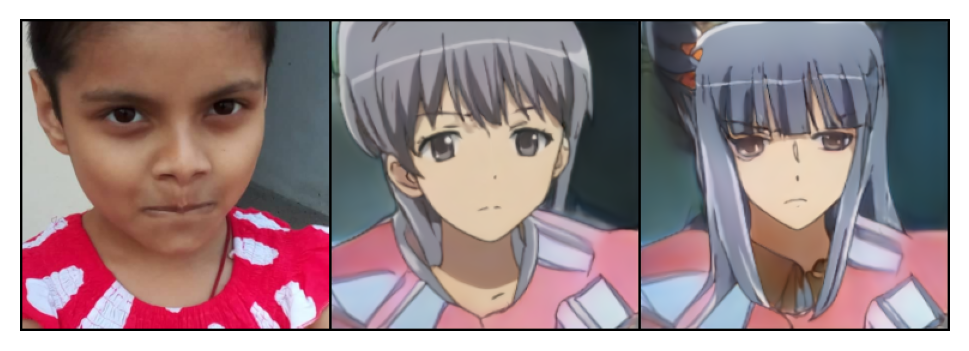

In [52]:

plt.rcParams['figure.dpi'] = 200

real_A = cropped_face
real_A = test_transform(real_A).unsqueeze(0).to(device)


eig_idx = 2 
eig_scale = 4 

style = G_A2B.mapping(torch.randn([1, latent_dim]).to(device))
direction = eig_scale * eigvec[:, eig_idx].unsqueeze(0).to(device)

with torch.no_grad():
    A2B_content, _ = G_A2B.encode(real_A)
    fake_A2B = G_A2B.decode(A2B_content, style, use_mapping=False)
    fake_A2B2 = G_A2B.decode(A2B_content, style+direction, use_mapping=False)

display_image(utils.make_grid(torch.cat([real_A, fake_A2B, fake_A2B2], 0).cpu(), normalize=True, range=(-1, 1)))

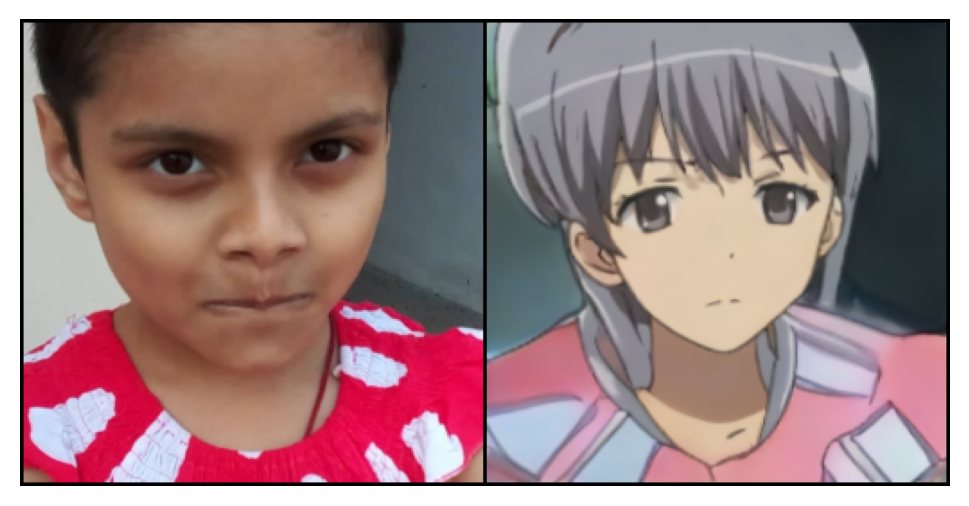

In [53]:
display_image(utils.make_grid(torch.cat([real_A, fake_A2B], 0).cpu(), normalize=True, value_range=(-1, 1)))

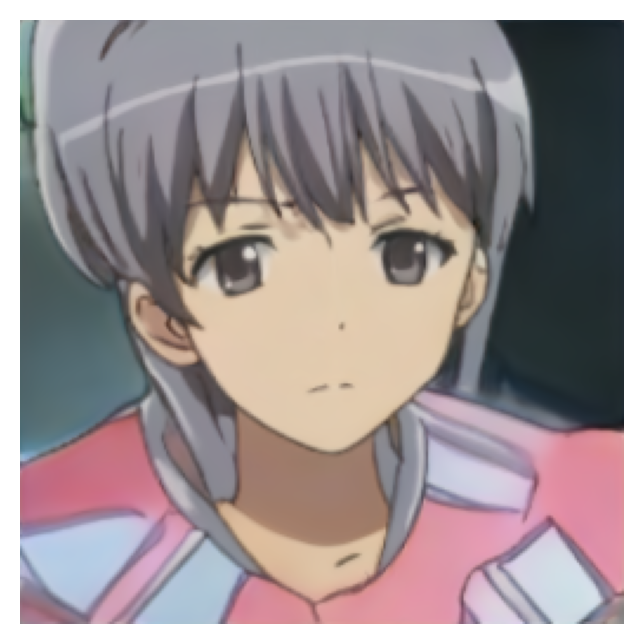

In [54]:
imo = display_image(utils.make_grid(torch.cat([fake_A2B], 0).cpu(), normalize=True, value_range=(-1, 1)))
imo

In [55]:
from IPython.display import display, Javascript,HTML
from google.colab.output import eval_js
from base64 import b64decode
 
def record_video(filename):
  js=Javascript("""
    async function recordVideo() {
      const options = { mimeType: "video/webm; codecs=vp9" };
      const div = document.createElement('div');
      const capture = document.createElement('button');
      const stopCapture = document.createElement("button");
       
      capture.textContent = "Start Recording";
      capture.style.background = "orange";
      capture.style.color = "white";
 
      stopCapture.textContent = "Stop Recording";
      stopCapture.style.background = "red";
      stopCapture.style.color = "white";
      div.appendChild(capture);
 
      const video = document.createElement('video');
      const recordingVid = document.createElement("video");
      video.style.display = 'block';
 
      const stream = await navigator.mediaDevices.getUserMedia({audio:true, video: true});
     
      let recorder = new MediaRecorder(stream, options);
      document.body.appendChild(div);
      div.appendChild(video);
 
      video.srcObject = stream;
      video.muted = true;
 
      await video.play();
 
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
 
      await new Promise((resolve) => {
        capture.onclick = resolve;
      });
      recorder.start();
      capture.replaceWith(stopCapture);
 
      await new Promise((resolve) => stopCapture.onclick = resolve);
      recorder.stop();
      let recData = await new Promise((resolve) => recorder.ondataavailable = resolve);
      let arrBuff = await recData.data.arrayBuffer();
       
      stream.getVideoTracks()[0].stop();
      div.remove();
 
      let binaryString = "";
      let bytes = new Uint8Array(arrBuff);
      bytes.forEach((byte) => {
        binaryString += String.fromCharCode(byte);
      })
    return btoa(binaryString);
    }
  """)
  try:
    display(js)
    data=eval_js('recordVideo({})')
    binary=b64decode(data)
    with open(filename,"wb") as video_file:
      video_file.write(binary)
    print(f"Finished recording video at:{filename}")
  except Exception as err:
    print(str(err))

In [56]:
! pwd
! cd samples/
!pwd


/content/GANsNRoses
/content/GANsNRoses


In [57]:
uploaded = files.upload()
filepath = list(uploaded.keys())[0]

Saving Video2.mp4 to Video2 (2).mp4


In [60]:
inpath = filepath
outpath = '/output2.mp4'

mode = 'beat'
assert mode in ('normal', 'blend', 'beat', 'eig')

start_frame=0
end_frame=None
frame_num = 0
mp4_fps= 30
faces = None
smoothing_sec=.7
eig_dir_idx = 1 

frames = []
reader = cv2.VideoCapture(inpath)
num_frames = int(reader.get(cv2.CAP_PROP_FRAME_COUNT))

win_s = 512                 
hop_s = win_s // 2         

s = source(inpath, 0, hop_s)
samplerate = s.samplerate
o = tempo("default", win_s, hop_s, samplerate)
delay = 4. * hop_s

beats = []

total_frames = 0
while True:
    samples, read = s()
    is_beat = o(samples)
    if is_beat:
        this_beat = int(total_frames - delay + is_beat[0] * hop_s)
        beats.append(this_beat/ float(samplerate))
    total_frames += read
    if read < hop_s: break

beats = [math.ceil(i*mp4_fps) for i in beats]

if mode == 'blend':
    shape = [num_frames, 8, latent_dim] 
    all_latents = random_state.randn(*shape).astype(np.float32)
    all_latents = scipy.ndimage.gaussian_filter(all_latents, [smoothing_sec * mp4_fps, 0, 0], mode='wrap')
    all_latents /= np.sqrt(np.mean(np.square(all_latents)))
    all_latents = torch.from_numpy(all_latents).to(device)
else:
    all_latents = torch.randn([8, latent_dim]).to(device)
    
if mode == 'eig':
    all_latents = G_A2B.mapping(all_latents)
    
in_latent = all_latents


face_detector = dlib.get_frontal_face_detector()

assert start_frame < num_frames - 1
end_frame = end_frame if end_frame else num_frames

while reader.isOpened():
    _, image = reader.read()
    if image is None:
        break

    if frame_num < start_frame:
        continue
  
    height, width = image.shape[:2]

   
    if faces is None:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = face_detector(gray, 1)
    if len(faces):
        
        face = faces[0]


    x, y, size = get_boundingbox(face, width, height)
    cropped_face = image[y:y+size, x:x+size]
    cropped_face = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)
    cropped_face = Image.fromarray(cropped_face)
    frame = test_transform(cropped_face).unsqueeze(0).to(device)

    with torch.no_grad():
        A2B_content, A2B_style = G_A2B.encode(frame)
        if mode == 'blend':
            in_latent = all_latents[frame_num]
        elif mode == 'normal':
            in_latent = all_latents
        elif mode == 'beat':
            if frame_num in beats:
                in_latent = torch.randn([8, latent_dim]).to(device)
        
        if mode == 'eig':
            if frame_num in beats:
                direction = 3 * eigvec[:, eig_dir_idx].unsqueeze(0).expand_as(all_latents).to(device)
                in_latent = all_latents + direction
                eig_dir_idx += 1
                
            fake_A2B = G_A2B.decode(A2B_content.repeat(8,1,1,1), in_latent, use_mapping=False)
        else:
            fake_A2B = G_A2B.decode(A2B_content.repeat(8,1,1,1), in_latent)

        
        
        fake_A2B = torch.cat([fake_A2B[:4], frame, fake_A2B[4:]], 0)

        fake_A2B = utils.make_grid(fake_A2B.cpu(), normalize=True, range=(-1, 1), nrow=3)



    fake_A2B = fake_A2B.permute(1,2,0).cpu().numpy()
    frames.append(fake_A2B*255)

    frame_num += 1
        
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(frames, fps=mp4_fps)


clip.write_videofile('./temp.mp4')


!ffmpeg -i ./temp.mp4 -i $inpath -c copy -map 0:v:0 -map 1:a:0 $outpath -y
!rm ./temp.mp4

[MoviePy] >>>> Building video ./temp.mp4
[MoviePy] Writing video ./temp.mp4


100%|██████████| 76/76 [00:01<00:00, 42.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./temp.mp4 

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --ena

In [59]:
mp4 = open(outpath,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)